# Title

**Credit Risk Analysis**

Projek ini akan membahas mengenai faktor - faktor penyebab seorang nasabah memiliki status peminjaman yang tidak berisiko dan tidak berisiko. Dalam projek ini juga akan dibuat sebuah model machine learning untuk memprediksi nasabah memiliki status yang beresiko dan tidak beresiko berdasarkan data historisnya.

# Introduction

Saya Risqi Wahyu Permana (Hacktiv8 Batch HCK 6). Saya seorang fresh graduate dari teknik informatika tahun 2023 dan memutuskan mengikuti bootcamp di Hacktiv8 untuk memperdalam ilmu mengenai datascience.

# External Link 
- Dataset: https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset

# Working Area

## Import Libraries

In [1]:
#imported all the Libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#Clasifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Other Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from scipy.stats import chi2_contingency
import joblib

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Function

In [2]:
def normal(df,col):
    upper = df[col].mean() + (3 * df[col].std())
    lower = df[col].mean() - (3 * df[col].std())

    outlier = df[(df[col] <= lower) | (df[col] >= upper)]

    print('percentage: ', len(outlier)/df.shape[0] * 100, '%')

def skew(df, col, fold):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)

    IQR = Q3 - Q1

    upper = Q3 + (fold*IQR)
    lower = Q1 - (fold*IQR)

    outlier = df[(df[col] <= lower) | (df[col] >= upper)]

    print('percentage: ', len(outlier)/df.shape[0] * 100, '%')
    print('upper: ', upper)
    print('lower: ', lower)

In [3]:
#Function to plot distribution
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print(df[col].name + ' Kurtosis: ' + str(df[col].kurt()))
    print(df[col].name + ' Skewness: ' + str(df[col].skew()))
    if -0.5 <= df[col].skew() <= 0.5:
        print("Columns '{}' normal distribution".format(col))
        normal(df, col)
    elif df[col].skew() > 0.5:
        if df[col].skew() > 1:
            print("Columns '{}' extreme right skewed".format(col))
            skew(df, col, 3)
        else:
            print("Columns '{}' right skewed".format(col))
            skew(df, col, 1.5)
    elif df[col].skew() < -0.5:
        if df[col].skew() < 1:
            print("Columns '{}' extreme left skewed".format(col))
            skew(df, col, 3)
        else:
            print("Columns '{}' left skewed".format(col))
            skew(df, col, 1.5)

## Data Loading

Jumlah dataset yang digunakan sebanyak kira - kira 880.000 ribu data.

In [4]:
#Data Loading
pd.set_option('display.max_columns', None) #show all columns
data = pd.read_csv('loan.csv')
data.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.00,0.00,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.00,0.00,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.00,0.00,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.90,766.90,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,Veolia Transportaton,3 years,RENT,36000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0.0,Nov-2004,3.0,NaN,NaN,9.0,0.0,7963.0,28.3,12.0,f,0.00,0.00,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-2015,161.03,NaN,Sep-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

## Feature Selection

---
### Penjelasan Kolom yang akan dipilih
---
feature dipilih berdasarkan domain knowledge.

Dataset name: `loan.csv`

| Column | Description |
| --- | --- |
| `loan_amnt` | Jumlah pinjaman yang tercantum yang diajukan oleh peminjam. Jika suatu saat departemen kredit mengurangi jumlah pinjaman, maka akan tercermin dalam nilai ini.|
| `funded_amnt_inv` | Jumlah total yang diberikan oleh investor untuk pinjaman tersebut pada saat itu. |
| `term` | Jumlah pembayaran pinjaman. Nilai dalam bulan dan dapat berupa 36 atau 60. |
| `int_rate` | Suku Bunga Pinjaman. |
| `installment` | Pembayaran bulanan yang harus dibayarkan oleh peminjam jika pinjaman tersebut disetujui. |
| `grade` | Kelas pinjaman yang ditetapkan LC |
| `emp_length` | Lama bekerja dalam tahun. Nilai yang mungkin adalah antara 0 dan 10 di mana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih. |
| `home_ownership` | Status kepemilikan rumah yang diberikan oleh peminjam pada saat pendaftaran. Nilai-nilainya adalah: RENT, OWN, MORTGAGE, OTHER. |
| `annual_inc` | Pendapatan tahunan yang dilaporkan sendiri oleh peminjam saat pendaftaran. |
| `verification_status` | Menunjukkan apakah pendapatan diverifikasi oleh LC, tidak diverifikasi, atau jika sumber pendapatan diverifikasi |
| `loan_status` | Status pinjaman saat ini |
| `purpose` | Kategori yang disediakan oleh peminjam untuk permintaan pinjaman. |
| `total_pymnt` | Pembayaran yang diterima hingga saat ini untuk jumlah total yang didanai |

In [6]:
# get selected features
selected_features = ['loan_amnt', 'funded_amnt_inv', 'term','int_rate',
                    'installment', 'grade', 'emp_length', 'home_ownership',
                    'annual_inc', 'verification_status', 'purpose', 'total_pymnt',
                    'loan_status']

# get selected features
df = data[selected_features]
df.head()

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,total_pymnt,loan_status
0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,credit_card,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,car,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,small_business,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,other,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,other,3242.170000,Current


## EDA for Modeling

Pada section ini berguna untuk melihat karakteristik data dan mengubahnya jika perlu untuk keperluan modeling.

Kolom emp_length dan annual_inc memiliki nilai null.

In [7]:
#check null
df.isnull().sum()

loan_amnt                  0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
emp_length             44825
home_ownership             0
annual_inc                 4
verification_status        0
purpose                    0
total_pymnt                0
loan_status                0
dtype: int64

### Kolom emp_length 

Handle Null value pada emp_length

In [8]:
df.emp_length.value_counts(dropna=False)

10+ years    291569
2 years       78870
< 1 year      70605
3 years       70026
1 year        57095
5 years       55704
4 years       52529
NaN           44825
7 years       44594
8 years       43955
6 years       42950
9 years       34657
Name: emp_length, dtype: int64

Kita bisa drop NaN pada kolom emp_length karena data tersebut masih layak untuk didrop mengingat total jumlah data kita sebanyak 887379. 

In [9]:
#drop NaN on emp_length
df = df.dropna(subset=['emp_length'])

### Kolom annual_inc

Handle Null value pada annual_inc

In [10]:
#fill 0
df['annual_inc'] = df['annual_inc'].fillna(0)

### Kolom emp_title

In [11]:
#Handle emp_title for EDA purposes
data['emp_title'].fillna('Unknown', inplace=True)
data['emp_title'].value_counts(dropna=False).head(11)

Unknown             51462
Teacher             13469
Manager             11240
Registered Nurse     5525
Owner                5376
RN                   5355
Supervisor           4983
Sales                4212
Project Manager      3988
Driver               3569
Office Manager       3510
Name: emp_title, dtype: int64

### Kolom home_ownership

Pada kolom home_ownership terdapat value `None` dan `ANY`. Kedua kolom tersebut akan kita gabungkan menjadi satu value yaitu `OTHER`.

In [12]:
# value NONE and ANY in column home_ownership change to OTHER
df['home_ownership'] = df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

### Kolom loan_status

Kita akan memodifikasi loan status menjadi dua kategori. Kategori pertama adalah Not Risk dimana terdiri dari status yang aman dan Risk yang arti tidak aman. Untuk kategori Issued akan kita hapus karena status tersebut tidak masuk kedalam kedua kategori yang ingin dibuat.

### Penjelasan Kolom
---
| Loan Status | Deskripsi |
| --- | --- |
| `Current` | Status pinjaman saat ini berada dalam kondisi yang baik dan pembayaran dilakukan tepat waktu sesuai dengan perjanjian. |
| `Fully Paid` | Pinjaman telah dibayar sepenuhnya, termasuk semua pokok pinjaman dan bunga yang jatuh tempo. |
| `Charged Off` | Pinjaman dianggap sebagai piutang yang tidak dapat dipulihkan oleh pemberi pinjaman setelah melalui serangkaian langkah penagihan. Ini biasanya terjadi ketika peminjam telah melewati batas waktu tertentu tanpa membayar, dan pemberi pinjaman menganggap bahwa kemungkinan untuk mendapatkan pembayaran penuh sangat rendah. |
| `Issued` | Pinjaman telah disetujui dan diberikan kepada peminjam, tetapi pembayaran mungkin belum dimulai. |
| `Late (31-120 days)` | Pinjaman sudah lewat batas waktu pembayaran yang ditetapkan (biasanya 31 hingga 120 hari), dan peminjam belum membayar secara tepat waktu. |
| `In Grace Period` | Peminjam berada dalam periode penangguhan pembayaran yang biasanya diberikan oleh pemberi pinjaman setelah tenggat waktu pembayaran lewat. Peminjam masih memiliki kesempatan untuk membayar tanpa dikenakan biaya keterlambatan. |
| `Late (16-30 days)` | Pinjaman lewat batas waktu pembayaran dalam rentang 16 hingga 30 hari. |
| `Does not meet the credit policy. Status:Fully Paid` | Pinjaman yang awalnya tidak memenuhi kebijakan kredit pemberi pinjaman, tetapi akhirnya telah dilunasi sepenuhnya. |
| `Default `| Peminjam gagal membayar pinjaman sesuai dengan perjanjian, dan pinjaman dianggap dalam keadaan gagal bayar. |
| `Does not meet the credit policy. Status:Charged Off` | Pinjaman yang awalnya tidak memenuhi kebijakan kredit pemberi pinjaman dan dianggap sebagai piutang yang tidak dapat dipulihkan setelah melewati langkah-langkah penagihan. |

In [13]:
df.loan_status.value_counts()

Current                                                568686
Fully Paid                                             200351
Charged Off                                             42723
Late (31-120 days)                                      10872
Issued                                                   7829
In Grace Period                                          6015
Late (16-30 days)                                        2215
Does not meet the credit policy. Status:Fully Paid       1969
Default                                                  1148
Does not meet the credit policy. Status:Charged Off       746
Name: loan_status, dtype: int64

In [14]:
# drop Issued value on column loan_status
df = df[df['loan_status'] != 'Issued']

In [15]:
#Make Current & Fully Paid as 0 else 1
df['loan_status'] = df['loan_status'].apply(lambda x: 0 if x in ['Current','Fully Paid'] else 1)

### Drop Duplicated Data

In [16]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [17]:
data.shape

(887379, 74)

### Split Data

Untuk mencegah data leaking, sebelum dilakukan preprocesing lebih lanjut maka data akan displit terlebih dahulu.

In [18]:
#split data
X = df.drop('loan_status',axis=1)
y = df['loan_status']

#split data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [19]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (583863, 12)
X_test shape:  (250227, 12)


In [20]:
#Separate the numerical and categorical columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

df_num = df[num_cols]
df_cat = df[cat_cols]

### Data Categorical

Pada section ini, akan kita analisa masing - masing kolom kategorikal untuk menentukan cara yang tepat untuk dihandle.

In [21]:
#see all df_cat unique values. Down list
for col in df_cat.columns:
    print("Column: ", col)
    print(df_cat[col].unique())
    print("")


Column:  term
[' 36 months' ' 60 months']

Column:  grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']

Column:  emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']

Column:  home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER']

Column:  verification_status
['Verified' 'Source Verified' 'Not Verified']

Column:  purpose
['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']



Berdasarkan value yang berada pada masing - masing kolom akan dilakukan teknik encoding sebagai berikut:
- One Hot Encoding (Tidak Memiliki Urutan)
    - term
    - home_ownership
    - verification_status
    - purpose
- Ordinal Encoding (Memiliki Urutan)
    - grade
    - emp_length

### Numerical Data

Pada section ini, akan dilakukan pengecekan distribusi data untuk menentukan bagaimana outlier pada kolom numerik akan dihandle.

In [22]:
df_num.head()

,loan_amnt,funded_amnt_inv,int_rate,installment,annual_inc,total_pymnt
0,5000.0,4975.0,10.65,162.87,24000.0,5861.071414
1,2500.0,2500.0,15.27,59.83,30000.0,1008.710000
2,2400.0,2400.0,15.96,84.33,12252.0,3003.653644
3,10000.0,10000.0,13.49,339.31,49200.0,12226.302212
4,3000.0,3000.0,12.69,67.79,80000.0,3242.170000


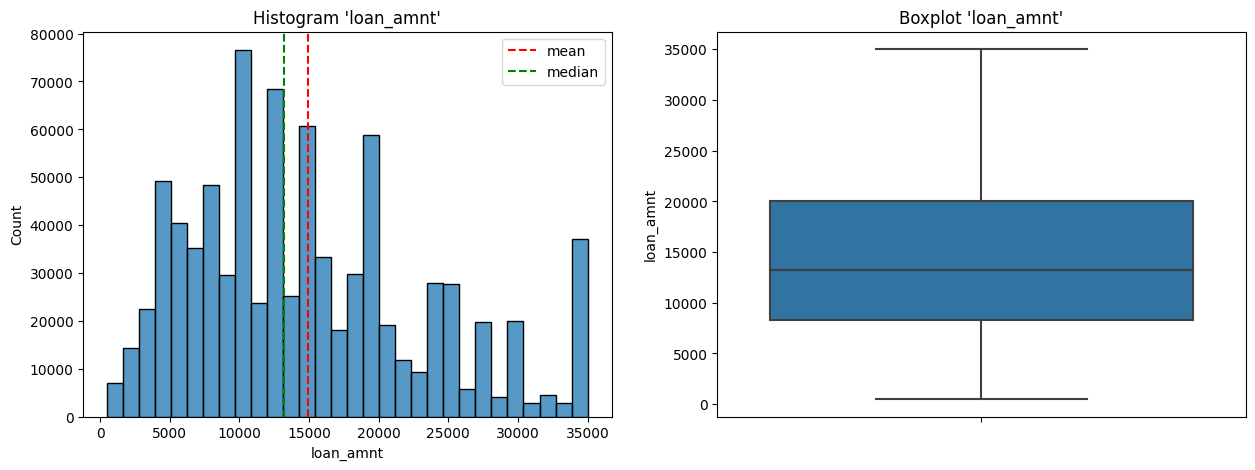

loan_amnt Kurtosis: -0.2813489602946535
loan_amnt Skewness: 0.6673066602537001
Columns 'loan_amnt' right skewed
percentage:  0.0 %
upper:  37512.5
lower:  -9187.5


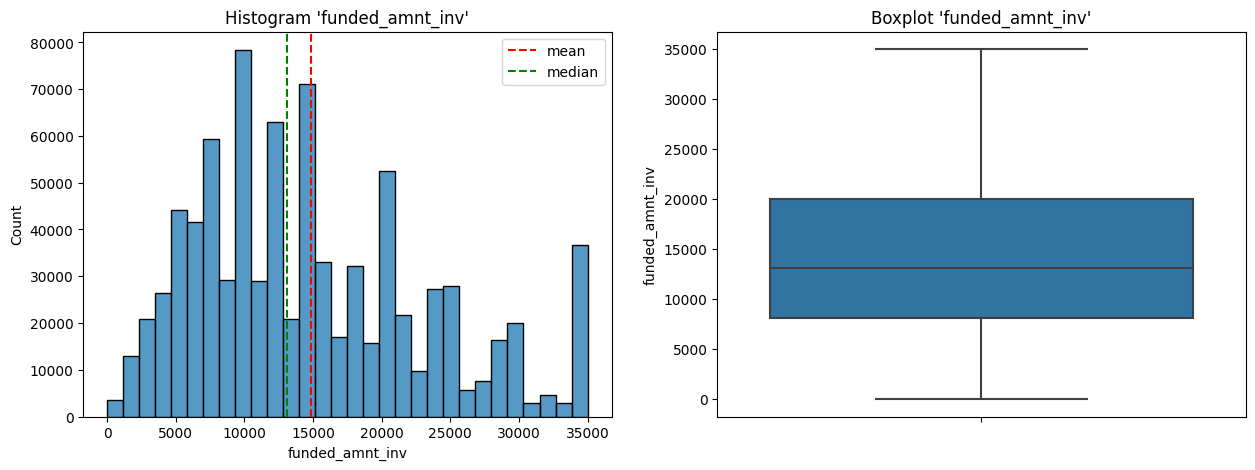

funded_amnt_inv Kurtosis: -0.2764180173154487
funded_amnt_inv Skewness: 0.6662588208000828
Columns 'funded_amnt_inv' right skewed
percentage:  0.0 %
upper:  37812.5
lower:  -9687.5


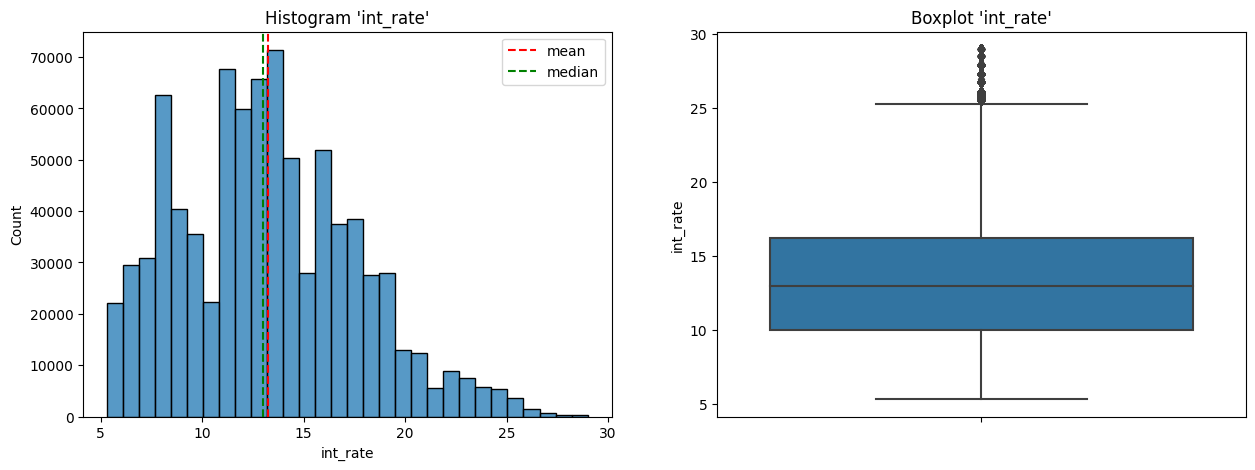

int_rate Kurtosis: -0.15769957677891355
int_rate Skewness: 0.4302920074492786
Columns 'int_rate' normal distribution
percentage:  0.1426704552266542 %


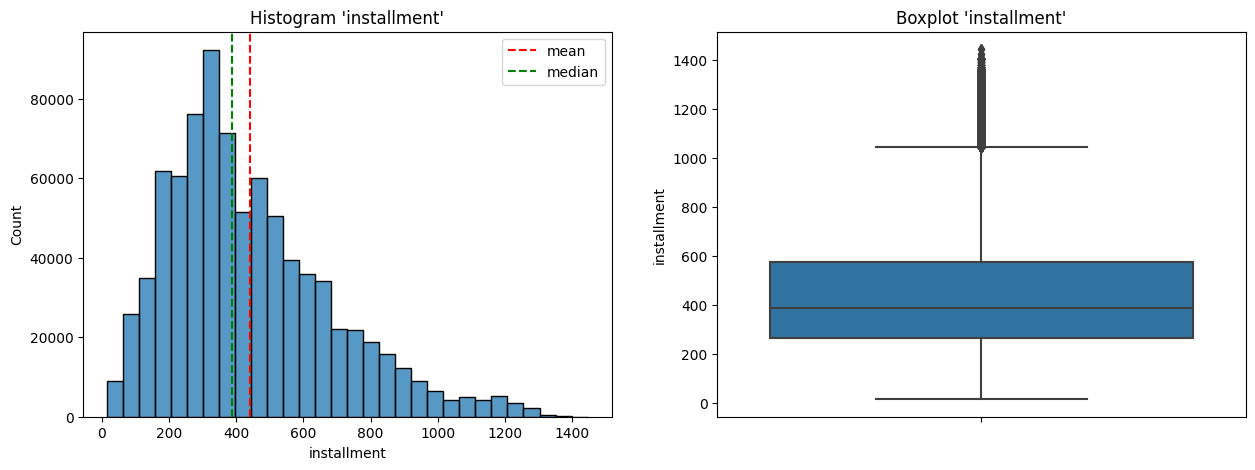

installment Kurtosis: 0.6634304127963859
installment Skewness: 0.9277754081058072
Columns 'installment' right skewed
percentage:  2.594084571209342 %
upper:  1047.3799999999999
lower:  -206.13999999999993


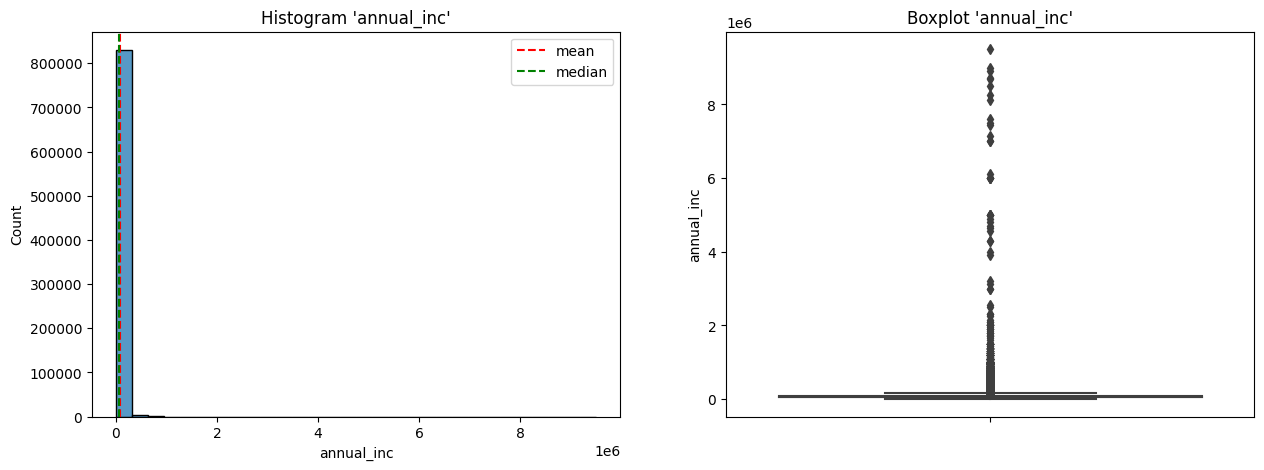

annual_inc Kurtosis: 4804.275526425695
annual_inc Skewness: 44.865673626396116
Columns 'annual_inc' extreme right skewed
percentage:  1.6667266122360895 %
upper:  219000.0
lower:  -82000.0


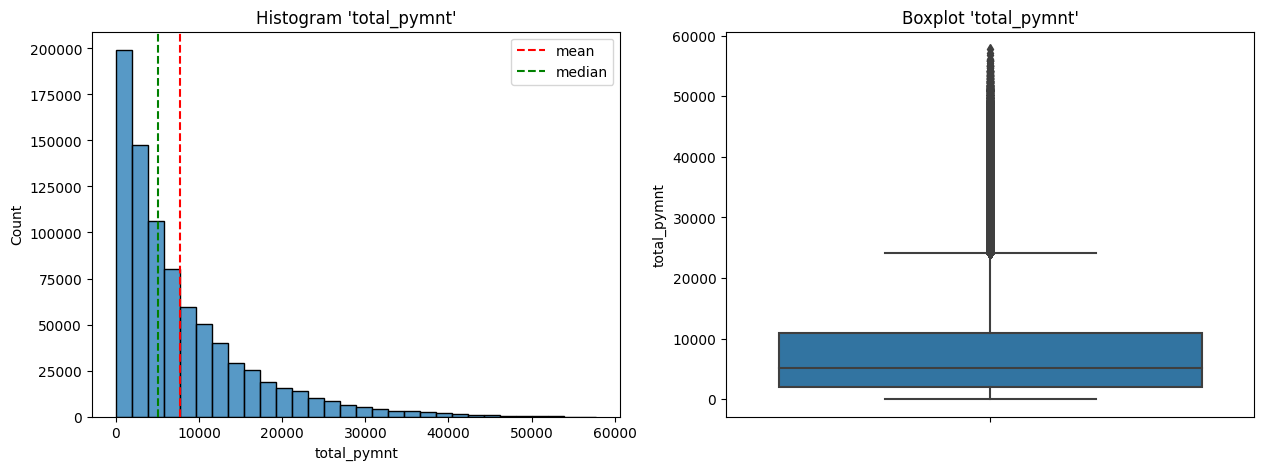

total_pymnt Kurtosis: 3.483526551256152
total_pymnt Skewness: 1.7621168149515996
Columns 'total_pymnt' extreme right skewed
percentage:  0.8967857185675406 %
upper:  37415.607500000006
lower:  -24518.852500000005


In [23]:
for i in num_cols:
    plot_dist(df_num, i)

Berdasarkan hasil pengecekan diatas, maka kolom yang memiliki outliers akan dihandle berdasarkan distribusi datanya.

Distribusi Skew:
- installment (IQR x 1,5)
- annual_inc (IQR x 3)
- total_pymnt (IQR x 3)

Distribusi Normal:
- int_rate

# Preprocessing

In [24]:
#Num pipe 1 for iqr x 1.5
num_pipe1 = Pipeline([
    ('wins1', Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['installment'])),
    ('scaler1', MinMaxScaler())
])

#Num pipe 2 for iqr x 3
num_pipe2 = Pipeline([
    ('wins2', Winsorizer(capping_method='iqr', tail='both', fold=3, variables=['annual_inc', 'total_pymnt'])),
    ('scaler2', MinMaxScaler())
])

#Num pipe 3 for gaussian/normal distribution
num_pipe3 = Pipeline([
    ('wins3', Winsorizer(capping_method='gaussian', tail='both', variables=['int_rate'])),
    ('scaler3', MinMaxScaler())
])

#Ordinal Ecoding
#Define rank
grade_rank = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
emp_length_rank = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']

cat_pipe1 = Pipeline([
    ('ord_enc', OrdinalEncoder(categories=[grade_rank, emp_length_rank])),
])

#One Hot Encoding
cat_pipe2 = Pipeline([
    ('one_hot_enc', OneHotEncoder(drop='first', sparse=False)),
])

#Full Pipeline
full_pipe = ColumnTransformer([
    ('num_pipe1', num_pipe1, ['installment']),
    ('num_pipe2', num_pipe2, ['annual_inc', 'total_pymnt']),
    ('num_pipe3', num_pipe3, ['int_rate']),
    ('cat_pipe1', cat_pipe1, ['grade', 'emp_length']),
    ('cat_pipe2', cat_pipe2, ['home_ownership', 'verification_status', 'purpose', 'term']),
])

#smotenc pipeline
#sampling_strategy=0.5 means the minority class will be 50% of the majority class
smote_pipe = imbPipeline([
    ('full_pipe', full_pipe),
    ('smote', SMOTENC(sampling_strategy=0.5, categorical_features=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                            17, 18, 19, 20, 21, 22, 23, 24], random_state=2020)),
])

In [25]:
smote_pipe

Pipeline(steps=[('full_pipe',
                 ColumnTransformer(transformers=[('num_pipe1',
                                                  Pipeline(steps=[('wins1',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              tail='both',
                                                                              variables=['installment'])),
                                                                  ('scaler1',
                                                                   MinMaxScaler())]),
                                                  ['installment']),
                                                 ('num_pipe2',
                                                  Pipeline(steps=[('wins2',
                                                                   Winsorizer(capping_method='iqr',
                                                                              tail='both',
                                                                              variables=['annual_inc',
                                                                                         'total_pymnt'])),
                                                                  (...
                                                                                               'years',
                                                                                               '9 '
                                                                                               'years',
                                                                                               '10+ '
                                                                                               'years']]))]),
                                                  ['grade', 'emp_length']),
                                                 ('cat_pipe2',
                                                  Pipeline(steps=[('one_hot_enc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['home_ownership',
                                                   'verification_status',
                                                   'purpose', 'term'])])),
                ('smote',
                 SMOTENC(categorical_features=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                               14, 15, 16, 17, 18, 19, 20, 21,
                                               22, 23, 24],
                         random_state=2020, sampling_strategy=0.5))])

In [26]:
#use smote_pipe to oversample the data
X_train_smote, y_train_smote = smote_pipe.fit_resample(X_train, y_train)
test_tr = full_pipe.transform(X_test)

In [27]:
X_train.shape

(583863, 12)

In [28]:
X_train_smote.shape

(807100, 25)

## EDA For Business

In [29]:
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,433067.000000,137053.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,221703.000000,887379.0,511.000000,509.000000,887350.000000,8.171030e+05,8.171030e+05,21372.000000,21372.000000,21372.000000,21372.000000,20810.000000,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.246513e+07,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,34.063798,70.117903,11.548469,0.195307,1.692079e+04,55.067693,25.268026,8403.124852,8399.713242,7558.826684,7521.160306,5757.706424,1754.804327,0.396692,45.919243,4.880757,2164.145585,0.014380,44.104838,1.0,109981.011585,18.310118,0.004991,2.257026e+02,1.394582e+05,1.109021,2.928832,0.761651,1.674574,20.912686,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.282734e+07,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,21.884940,28.127914,5.317313,0.582091,2.242679e+04,23.834344,11.840561,8493.450269,8489.997617,7871.243336,7846.108604,6625.441046,2095.356099,4.087825,409.693874,63.125281,4794.783233,0.134191,22.179841,0.0,52730.379847,7.169233,0.077625,1.031137e+04,1.537500e+05,1.242675,3.089987,0.996035,1.688725,27.209081,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17950.000000,3.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,9.206643e+06,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,0.000000,0.000000,1914.590000,1899.700000,1200.570000,441.460000,0.000000,0.000000,0.000000,280.170000,0.000000,27.000000,1.0,76032.500000,13.200000,0.000000,0.000000e+00,2.985300e+04,0.000000,1.000000,0.000000,0.000000,6.000000,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.443327e+07,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,6458.290000,6455.810000,4894.999117,4862.010000,3215.320000,1073.280000,0.000000,0.000000,0.000000,462.780000,0.000000,44.000000,1.0,101771.000000,17.610000,0.000000,0.000000e+00,8.055900e+04,1.000000,2.000000,0.000000,1.000000,12.000000,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.0000

### Home Ownership with target

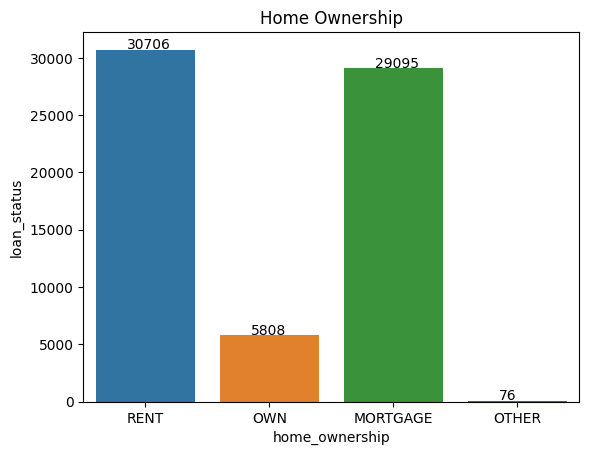

In [30]:
# count Home Ownership
ax = sns.barplot(x='home_ownership', y='loan_status',data=df,estimator=np.sum,ci=None)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+50))
plt.title('Home Ownership')
plt.show()

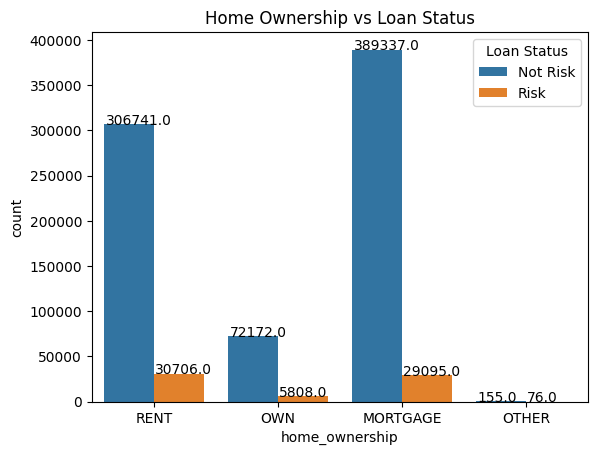

In [31]:
#make countplot of home_ownership with loan_status
ax = sns.countplot(x='home_ownership',hue='loan_status',data=df)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.010, p.get_height()+50))
plt.title('Home Ownership vs Loan Status')
new_labels = ['Not Risk', 'Risk']
plt.legend(title='Loan Status', loc='upper right', labels=new_labels)
plt.show()

Insight yang dapat diambil adalah nasabah yang masih menyewa rumah dan memiliki rumah namun belum lunas, lebih cenderung menggunakan kredit dibandingkan nasabah yang memiliki rumah tetap. Selain itu pada dua kategori 'Rent' dan 'Mortage', nasabah yang memiliki status kredit beresiko lebih banyak pada dua kategori itu.

### Employee length with target

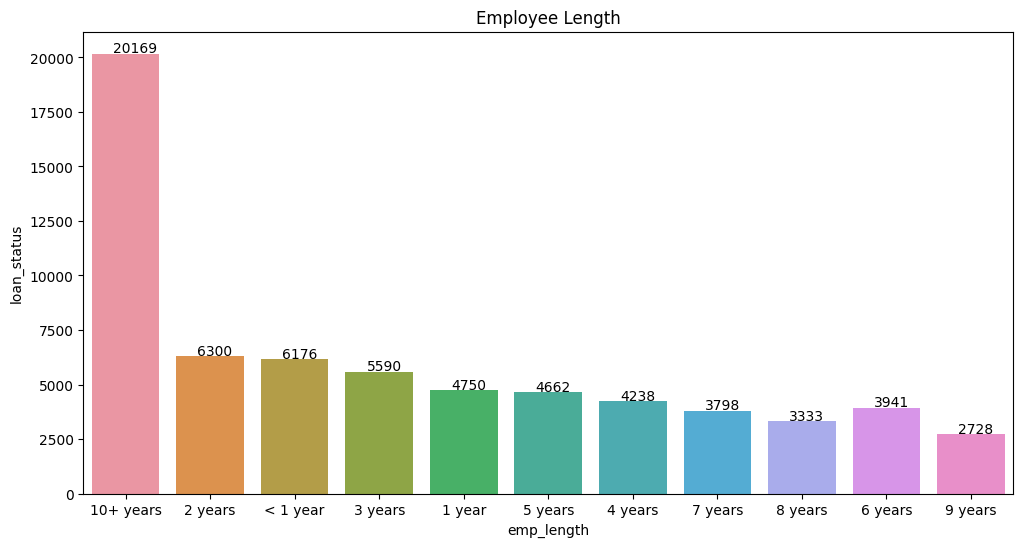

In [32]:
# count employee length
plt.figure(figsize=(12,6))
ax = sns.barplot(x='emp_length', y='loan_status',data=df,estimator=np.sum,ci=None, order = df['emp_length'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+50))
plt.title('Employee Length')
plt.show()

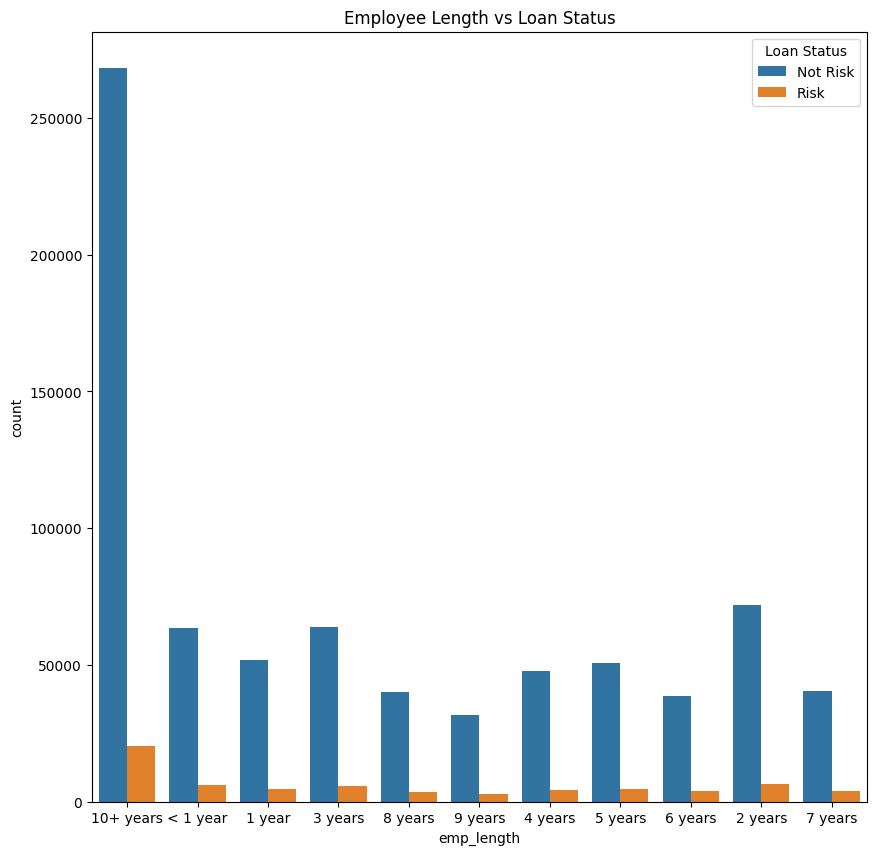

In [33]:
#make countplot of emp_length with loan_status
plt.figure(figsize=(10,10))
ax = sns.countplot(x='emp_length',hue='loan_status',data=df)
plt.title('Employee Length vs Loan Status')
new_labels = ['Not Risk', 'Risk']
plt.legend(title='Loan Status', loc='upper right', labels=new_labels)
plt.show()

Insight yang bisa didaptkan adalah mayoritas nasabah pengguna kredit memiliki pekerjaan lebih dari 10 tahun. Terlihat juga bahwa jumlah peminjam dengan status "Risk" cenderung lebih rendah pada lamanya pengalaman kerja yang lebih lama (seperti "10+ years") dan cenderung lebih tinggi pada lamanya pengalaman kerja yang lebih pendek (seperti "1 year", "< 1 year"). Ini bisa mengindikasikan bahwa peminjam dengan pengalaman kerja yang lebih lama mungkin lebih kreditabel atau lebih stabil secara finansial.

### Employee Title

In [34]:
emp_title = pd.DataFrame(data['emp_title'].value_counts())
emp_title = emp_title.reset_index()
emp_title.columns = ['emp_title', 'count']
# only keep the top 10
emp_title = emp_title[:5]


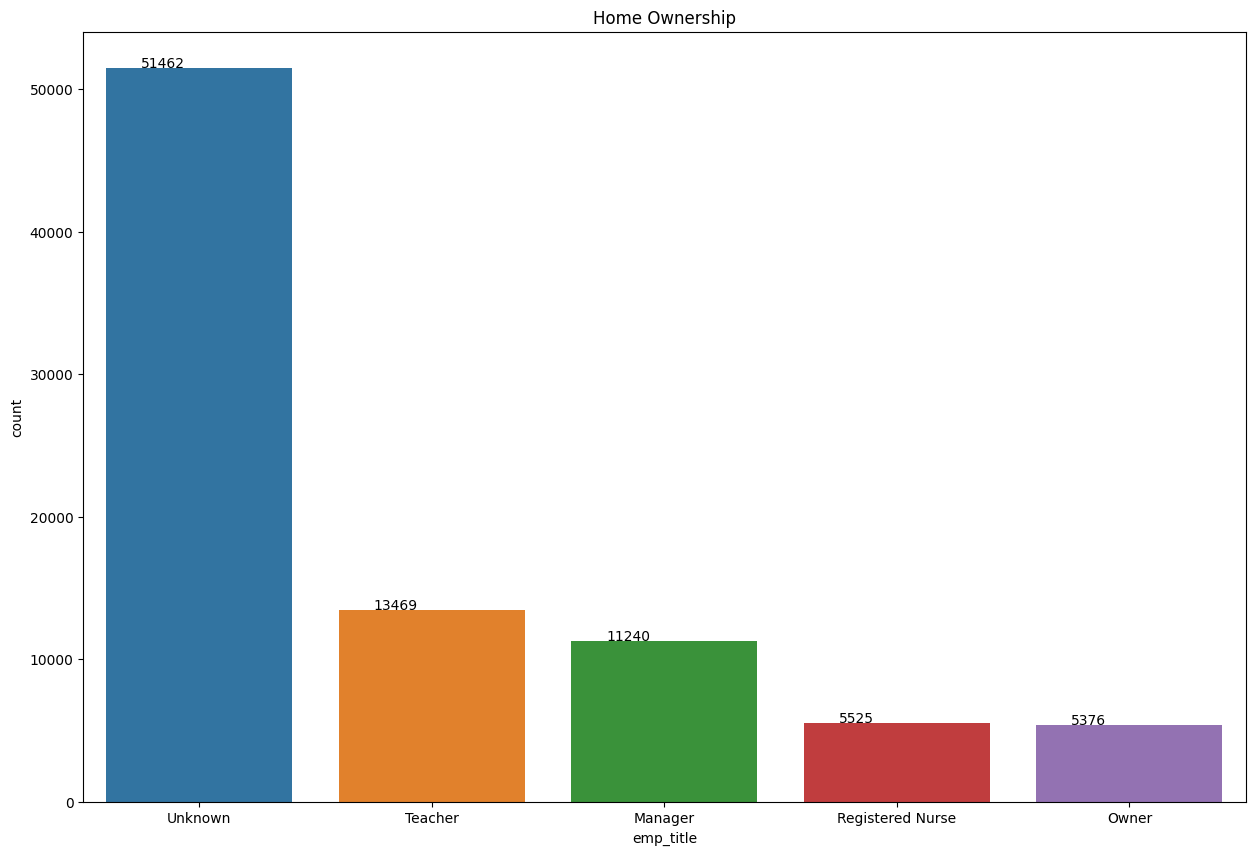

In [35]:
# count Employee Title
plt.figure(figsize=(15,10))
ax = sns.barplot(x='emp_title', y='count',data=emp_title,estimator=np.sum,ci=None)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))
plt.title('Home Ownership')
plt.show()

Insight yang bisa didapat adalah mayoritas nasabah tidak kita ketahui pekerjaanya. Mungkin untuk tim yang bersangkutan, dalam mengumpulkan data bisa diupayakan untuk bisa mengetahui pekerjaan nasabah. Untuk saat ini pekerjaan yang dapat diidentifikasi menggunakan kredit paling besar adalah profesi guru dan manager. Sehingga tim dapat menawarkan solusi pinjaman yang lebih sesuai atau mempertimbangkan pengembangan produk pinjaman yang disesuaikan dengan jenis pekerjaan tertentu. Misalnya, produk pinjaman pendidikan untuk peminjam yang bekerja di sektor pendidikan, atau produk pinjaman bisnis untuk peminjam yang memiliki bisnis sendiri.

### Correlation Term with Loan Status

In [36]:
contingency_table = pd.crosstab(df['term'], df['loan_status'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [37]:
# Interpretasi hasil
alpha = 0.05
print(f'Chi-squared value: {chi2}')
print(f'p-value: {p}')
print('')
if p < alpha:
    print("Kita dapat menolak hipotesis nol: Ada hubungan antara jangka waktu pinjaman dan kinerja pinjaman.")
else:
    print("Kita gagal menolak hipotesis nol: Tidak ada bukti cukup untuk menyimpulkan adanya hubungan.")

Chi-squared value: 1150.3152086181956
p-value: 3.8316084963367897e-252

Kita dapat menolak hipotesis nol: Ada hubungan antara jangka waktu pinjaman dan kinerja pinjaman.


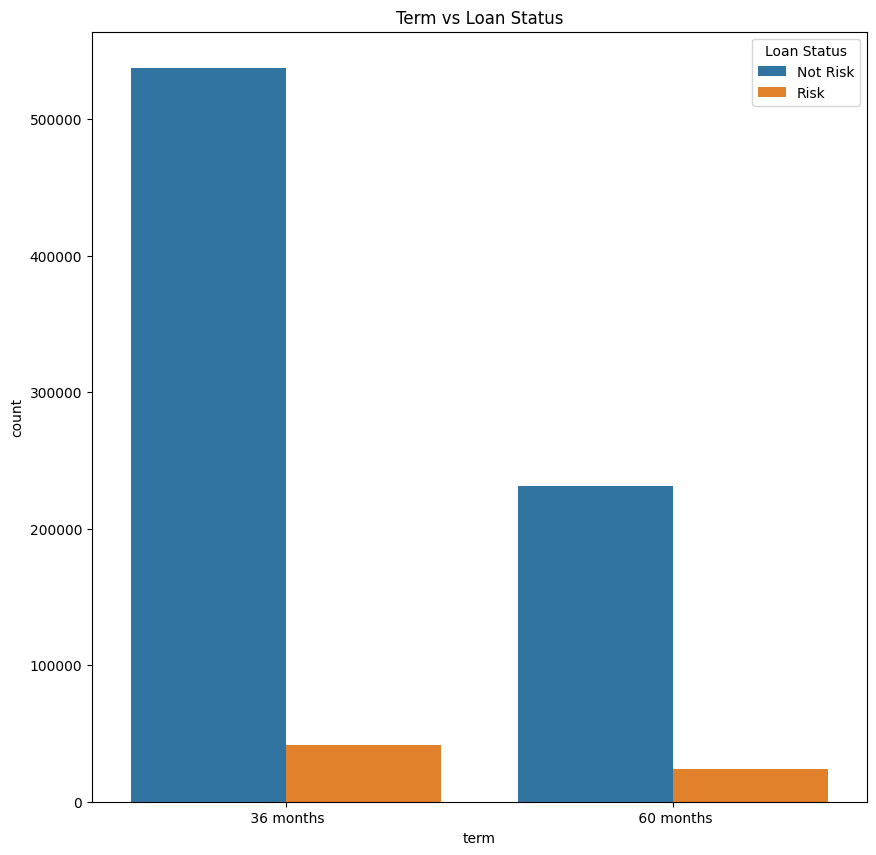

In [38]:
#make countplot of emp_length with loan_status
plt.figure(figsize=(10,10))
ax = sns.countplot(x='term',hue='loan_status',data=df)
plt.title('Term vs Loan Status')
new_labels = ['Not Risk', 'Risk']
plt.legend(title='Loan Status', loc='upper right', labels=new_labels)
plt.show()

Insight yang bisa didapatkan adalah bisa dilihat bahwa sebagian besar pinjaman memiliki jangka waktu 36 bulan (3 tahun), sedangkan sebagian lebih kecil memiliki jangka waktu 60 bulan (5 tahun). Terdapat juga perbedaan jumlah antara pinjaman dengan status "Not Risk" dan "Risk" untuk kedua jangka waktu. Ini mengindikasikan bahwa jangka waktu pinjaman dapat berdampak pada kinerja pinjaman. Hal itu dibuktikan juga dengan uji chi-square untuk mengetahui apakah ada hubungannya antara term dengan loan_status. Hasil yang didapatkan adalah tolak H0 yang dimana ada hubungan antara jangka waktu pinjaman dan kinerja pinjaman.

Meskipun jumlah pinjaman dengan jangka waktu 60 bulan lebih sedikit, proporsi jumlah pinjaman dengan tatus "Risk" relatif lebih tinggi dibandingkan dengan jangka waktu 36 bulan.
Ini bisa mengindikasikan bahwa pinjaman dengan jangka waktu lebih lama cenderung memiliki risiko kredit yang lebih tinggi. Sehingga tim dapat mempertimbangkan risiko kredit secara lebih cermat ketika memberikan pinjaman dengan jangka waktu yang lebih lama (60 bulan). Peminjam dengan jangka waktu pinjaman yang lebih lama mungkin memiliki risiko kredit yang lebih tinggi, dan langkah-langkah pencegahan tambahan mungkin diperlukan.


### Purpose With Loan Status

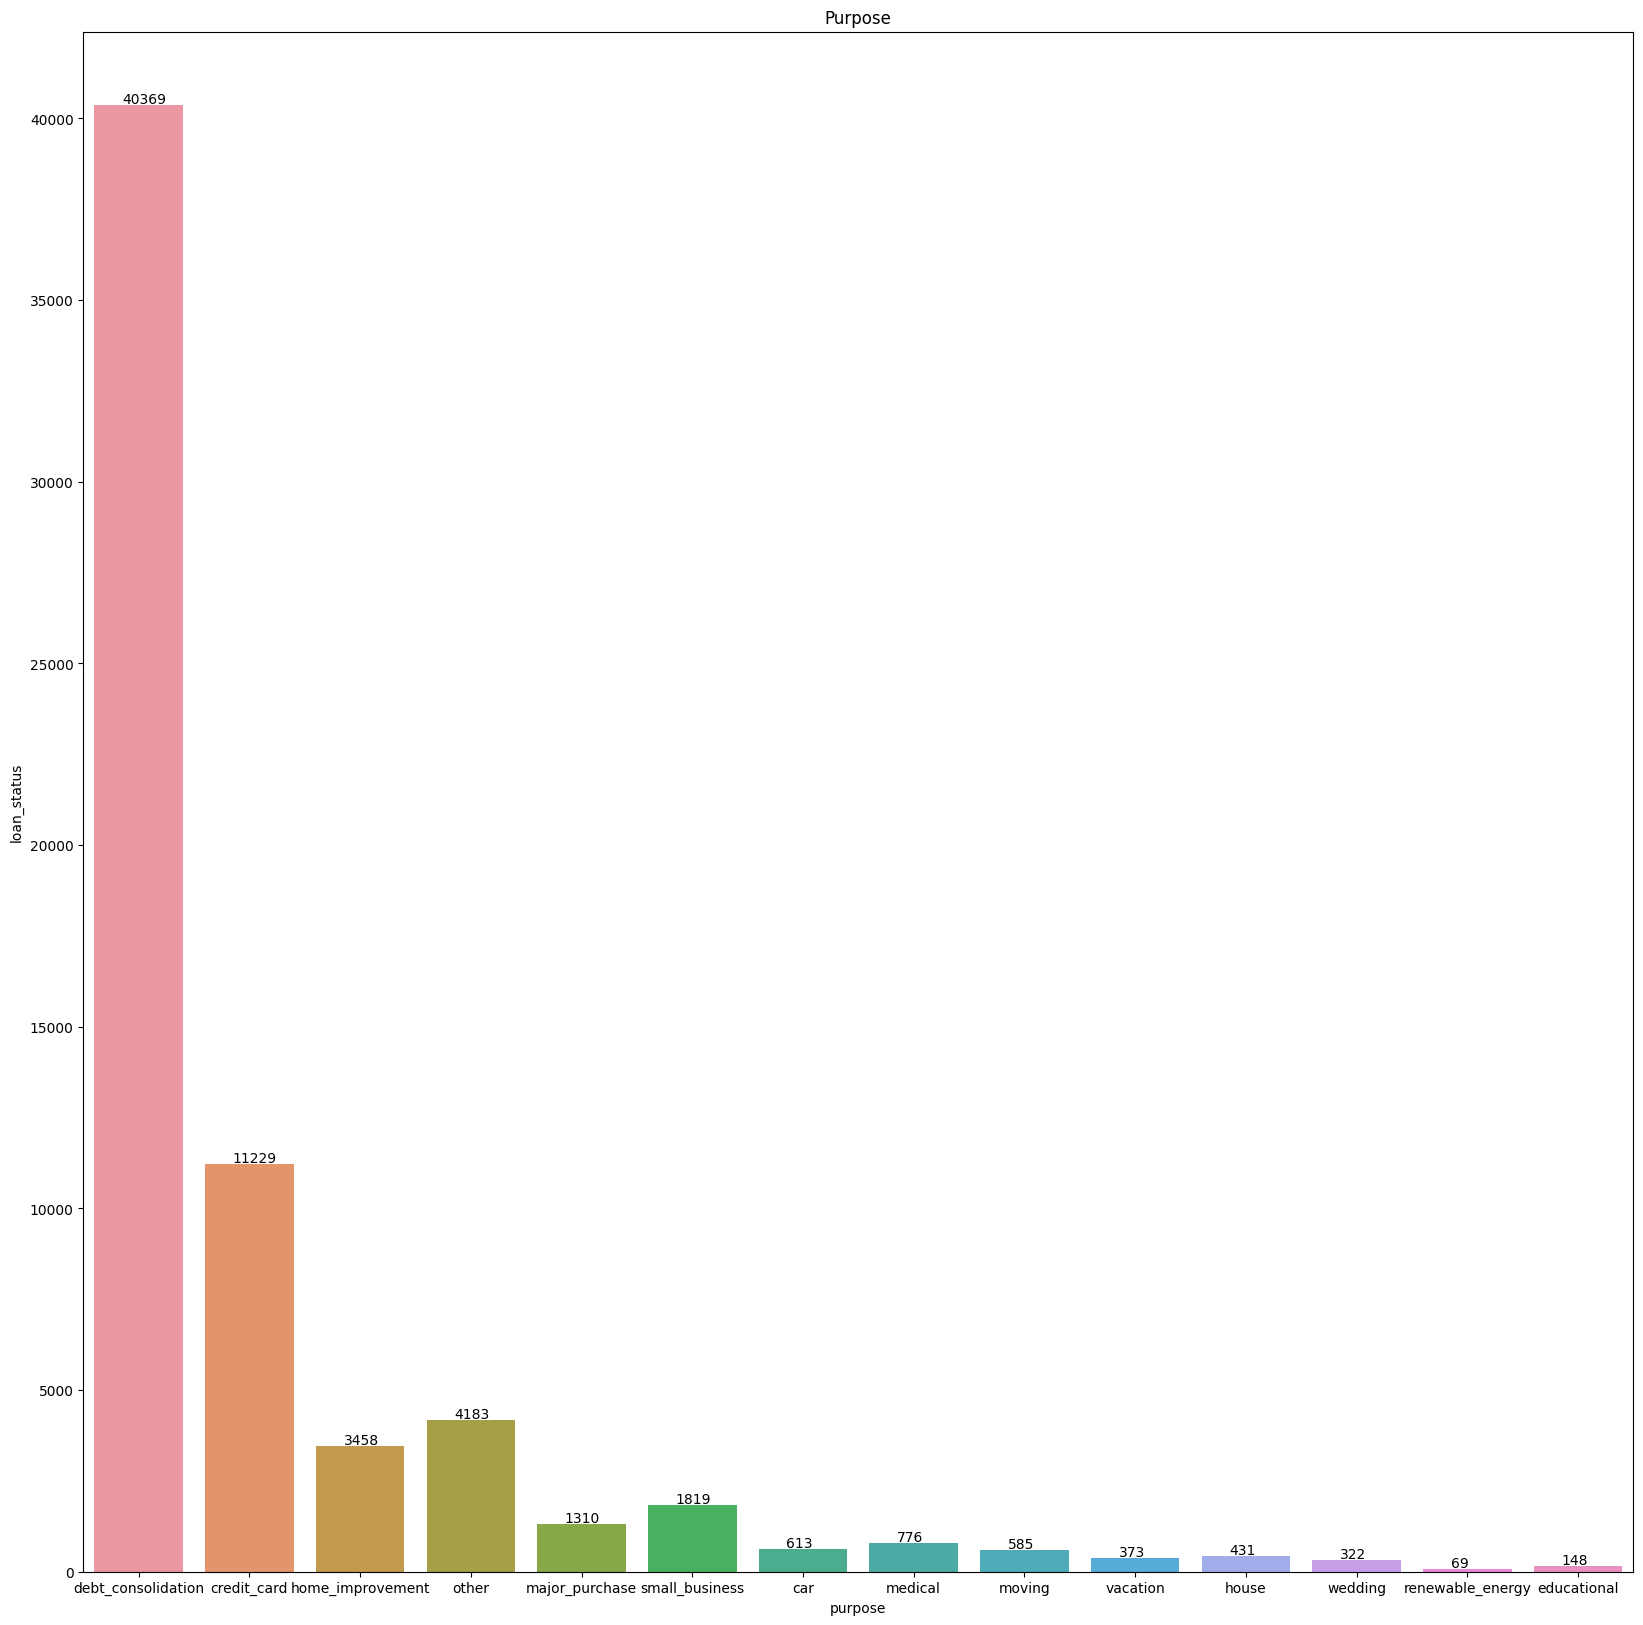

In [39]:
# count employee length
plt.figure(figsize=(20,20))
ax = sns.barplot(x='purpose', y='loan_status',data=df,estimator=np.sum,ci=None, order=df['purpose'].value_counts().index)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+50))
plt.title('Purpose')
plt.show()

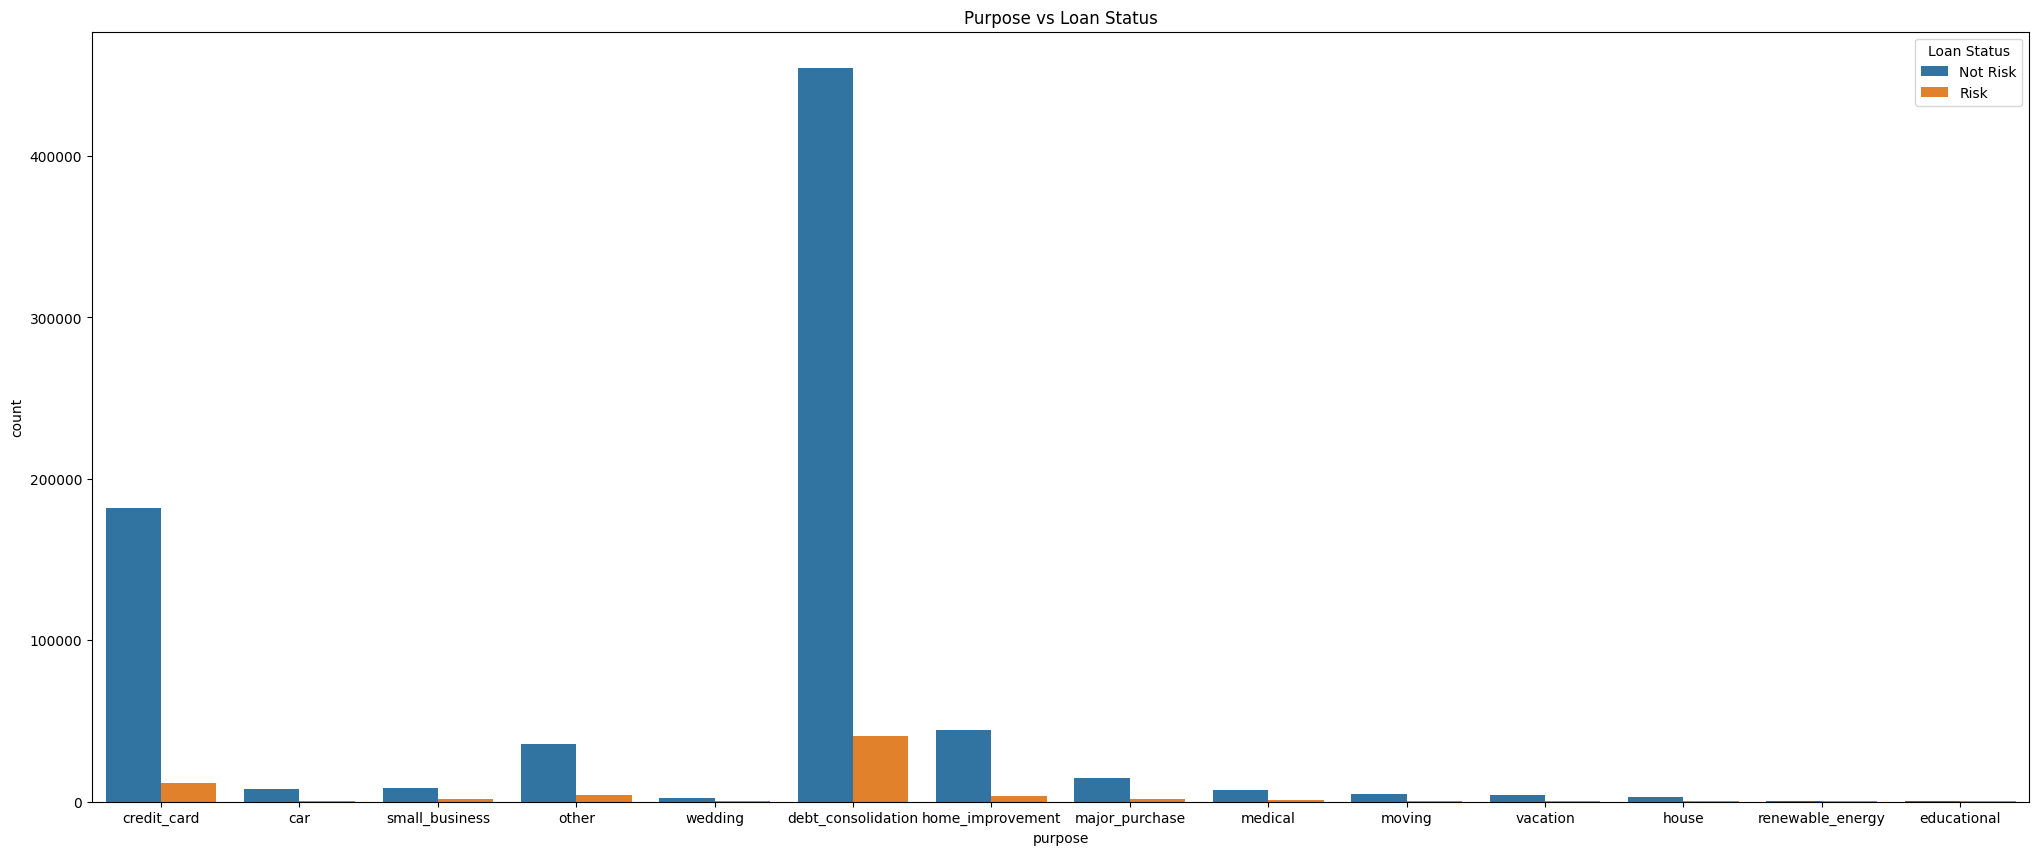

In [40]:
#make countplot of emp_length with loan_status
plt.figure(figsize=(25,10))
ax = sns.countplot(x='purpose',hue='loan_status',data=df)
plt.title('Purpose vs Loan Status')
new_labels = ['Not Risk', 'Risk']
plt.legend(title='Loan Status', loc='upper right', labels=new_labels)
plt.show()

Text(0.5, 1.0, 'Loan Amounts grouped with Purpose')

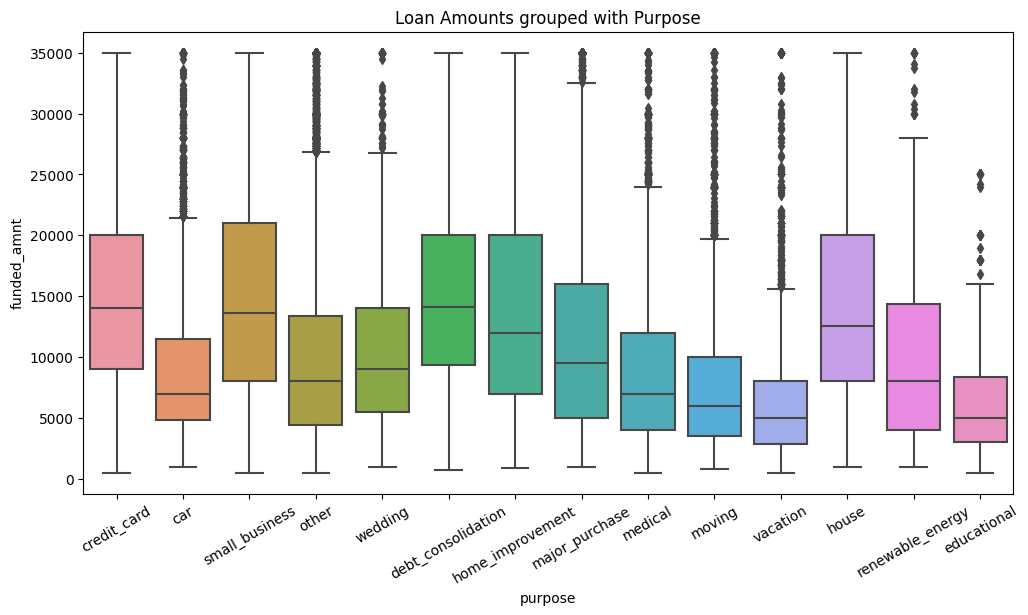

In [41]:
plt.figure(figsize=(12,6))
sns.boxplot(x='purpose', y='funded_amnt', data=data)
plt.xticks(rotation=30)
plt.title('Loan Amounts grouped with Purpose')

Insight yang bisa didapatkan adalah untuk tujuan peminjaman Debt Consolidation" (konsolidasi hutang) adalah tujuan peminjaman yang paling umum, diikuti oleh "Credit Card" (kartu kredit) dan "Home Improvement" (perbaikan rumah). "Educational" (pendidikan) dan "Renewable Energy" (energi terbarukan) adalah tujuan peminjaman yang paling jarang.

Dalam beberapa tujuan peminjaman seperti "Credit Card," "Home Improvement," dan "Major Purchase," jumlah pinjaman dengan status "Not Risk" jauh lebih tinggi daripada yang memiliki status "Risk.". Sedangkan tujuan peminjaman seperti "Small Business," "Other," dan "Debt Consolidation," proporsi pinjaman dengan status "Risk" lebih tinggi dibandingkan dengan status "Not Risk.".

Dapat kita lihat juga pada box plot beberapa tujuan peminjaman yang melebihi dari nilai median. Ini menujukan indikasi peminjaman berlebih.

# Modeling

In [42]:
#Menggunakan dua model machine learning yaitu Logistic Regression dan Random Forest Classifier kemudian membandingkan hasilnya
logreg = LogisticRegression()
rfc = RandomForestClassifier()

In [43]:
# straified k-fold untuk membagi data menjadi 2 bagian
stratified_kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)

In [44]:
# cross-val score for logistic regression
scores_lr = cross_val_score(logreg, X_train_smote, y_train_smote,
                            scoring='roc_auc', cv=stratified_kfold)

print(scores_lr)
print(scores_lr.mean())

[0.7315734  0.73111278]
0.7313430895237456


In [45]:
# cross-val score for Random Forest Classifier
scores_rfc = cross_val_score(rfc, X_train_smote, y_train_smote,
                            scoring='roc_auc', cv=stratified_kfold)

print(scores_rfc)
print(scores_rfc.mean())

[0.96738406 0.96734599]
0.9673650236767756


Random forest memiliki nilai score yang lebih tinggi, sehingga akan digunakan random forest sebagi model untuk memprediksi credit risk.

In [46]:
#hyperparameter tuning rfc
param_rfc= {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [47]:
# Initialize GridSearchCV
grid_search = GridSearchCV(rfc, param_grid=param_rfc,
                           scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train_smote, y_train_smote)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [48]:
# Get the best hyperparameters and their corresponding accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy Score:", best_score)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy Score: 0.9681362726690768


In [49]:
print(grid_search.best_estimator_)

RandomForestClassifier(n_estimators=200)


Ternyata paramater yang digunakan adalah yang default kecuali parameter n_estimators yang menggunakan 200 n_estimators.

In [50]:
model = grid_search.best_estimator_
model.fit(X_train_smote, y_train_smote)

model_test = model.predict(test_tr)

In [51]:
print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    230338
           1       0.55      0.34      0.42     19889

    accuracy                           0.93    250227
   macro avg       0.75      0.66      0.69    250227
weighted avg       0.91      0.93      0.92    250227



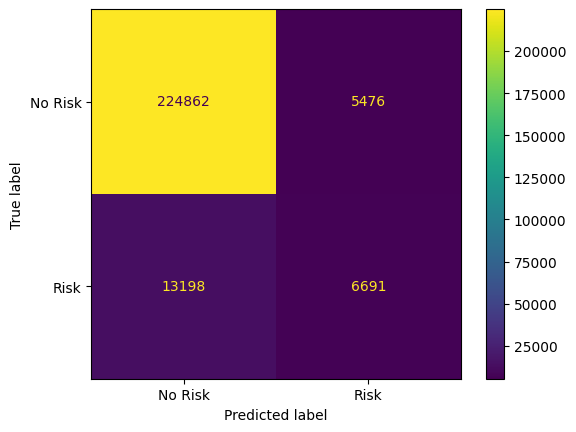

In [52]:
#confussion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model_test)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Risk', 'Risk'])
display.plot()

### Save Model

Deployment tidak dilakukan karena proses Smotenc membuat kompleksitas model menjadi rumit sehingga mempengaruhi ukuran model hingga 3 GB. Sehingga akan sulit untuk mengupload file besar tersebut ke server hugging face maupun github.

In [53]:
# final_pipeline = Pipeline([
#     ('preprocessing', full_pipe),
#     ('model', model)
# ])

In [54]:
# final_pipeline

In [55]:
#save model
# joblib.dump(final_pipeline, open('Credit_Score_Analysis.pkl', 'wb'))

In [56]:
# models = joblib.load(open('Credit_Score_Analysis.pkl', 'rb'))

In [57]:
# dummy_data = pd.DataFrame({
#     'loan_amnt': [12800.0, 6000.0, 10000.0, 30000.0, 9500.0, 15250.0],
#     'funded_amnt_inv': [12800.0, 6000.0, 10000.0, 30000.0, 9500.0, 15250.0],
#     'term': [' 60 months', ' 36 months', ' 36 months', ' 60 months', ' 36 months', ' 36 months'],
#     'int_rate': [13.35, 14.49, 9.67, 24.99, 13.99, 18.25],
#     'installment': [294.12, 206.44, 321.13, 1192.64, 324.65, 553.24],
#     'grade': ['C', 'C', 'B', 'F', 'C', 'D'],
#     'emp_length': ['5 years', '9 years', '7 years', '7 years', '2 years', '10+ years'],
#     'home_ownership': ['RENT', 'OWN', 'MORTGAGE', 'MORTGAGE', 'MORTGAGE', 'MORTGAGE'],
#     'annual_inc': [47500.0, 35000.0, 102000.0, 156000.0, 48000.0, 48000.0],
#     'verification_status': ['Verified', 'Source Verified', 'Not Verified', 'Source Verified', 'Source Verified', 'Source Verified'],
#     'purpose': ['other', 'debt_consolidation', 'debt_consolidation', 'debt_consolidation', 'debt_consolidation', 'credit_card'],
#     'total_pymnt': [5577.260000, 3717.000000, 7706.810000, 25076.460000, 1283.830000, 6085.640000]
# })

# dummy_data

In [58]:
# result = models.predict(dummy_data)
# dummy_data = pd.DataFrame(result, columns=['credit_status'])
# dummy_data['credit_status'] = dummy_data['credit_status'].map({0: 'Not Risk', 1: 'Risk'})
# dummy_data.head(6)

# Conclusion

Kesimpulan pada sisi bisnis:
- Bisa lebih diperhatikan lebih lanjut kategori - kategori yang mengindikasikan seorang nasabah memiliki resiko credit risk tinggi. Agar dapat menentukan langkah yang tepat untuk meminimalkan resiko.
- Personalisasi penawaran pinjaman atau pengembangan produk khusus kepada nasabah. Karena pada data yang kita dapatkan terdapat misalnya profesi tertentu yang banyak melakukan pinjaman. Kita bisa personalisasi atau mengembangkan produk khusus untuk menarik minat nasabah baru atau membuat pinjaman dari nasabah berprofesi lain yang masih rendah bisa meningkat.

Kesimpulan pada model:
- Metrik yang digunakan adalah roc_auc karena bisa digunakan untuk data yang inbalance
- Model mengalami overfit.
- Model kurang bagus dalam memprediksi nasabah yang memiliki kredit beresiko tinggi. Hal ini disebabkan oleh data yang tidak seimbang antara data target.

Saran untuk perbaikan model: 
- Bisa mencoba menggunakan model machine learning lain yang lebih tahan dengan data inbalance seperti Gradient Boosting, SVM, AdaBoost.
- Karena jumlah data yang banyak, bisa mempertimbangkan menggunakan deep learning. Selain itu, deep learning bisa menggunakan bobot untuk membantu dalam situasi data yang inbalance.
- Menggunakan Regularisasi untuk mengurangi overfitting.